In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="1" #model will be trained on GPU 1

In [2]:
import tensorflow.keras
import tensorflow as tf
from matplotlib import pyplot as plt
import numpy as np
import gzip
%matplotlib inline
from tensorflow.keras.layers import Input,Conv2D,MaxPooling2D,UpSampling2D, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import RMSprop
import pandas as pd
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.initializers import Constant, RandomNormal
import seaborn as sns
from scipy.misc import derivative
import scipy.integrate as intg
import scipy as sp


In [3]:
file = '../data/fs8Diagram.txt'
data = pd.read_csv(file, names=['z', '$f\sigma_8$', 'err', '$\Omega_ref$'], sep = "\t", skiprows=3)
data = data[['z', '$f\sigma_8$', 'err']]
# data.describe()
data

,z,$f\sigma_8$,err
0,0.020,0.4280,0.0465
1,0.020,0.3980,0.0650
2,0.020,0.3140,0.0480
3,0.100,0.3700,0.1300
4,0.150,0.4900,0.1450
5,0.170,0.5100,0.0600
6,0.180,0.3600,0.0900
7,0.380,0.4400,0.0600
8,0.250,0.3512,0.0583
9,0.370,0.4602,0.0378


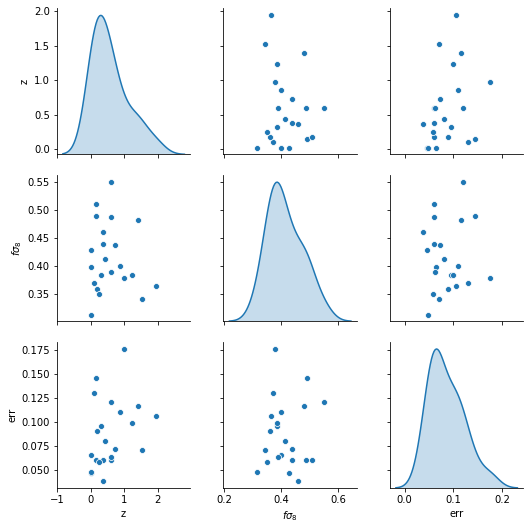

In [4]:
sns.pairplot(data, diag_kind="kde")
# plt.savefig("Distfs8.png")

In [5]:
# a= np.array([12,4,2,7,14,11,20,16,9,19,5,17,1,15,10,8,18,21,0,13,3,6])
# a = np.array([21,1,3,10,12,17,8,4,7,16, 2,11,19,13,18,5,9,20,15,14,6,0])
shuffle = [x for x in range(len(data.values)) if x%2 ==1]
even = [x for x in range(len(data.values)) if x%2 ==0]
shuffle.extend(even)
# randomize = np.random.permutation(len(data.values))
data = data.values[shuffle]
# array([17, 10,  1, 19, 12,  8, 14, 18,  4,  3,  6,  9, 21, 16,  2, 15,  0,
#        20,  7,  5, 11, 13])
# array([ 1, 15, 12, 20, 21,  3, 18, 13,  7, 19,  9,  8, 14,  6, 11,  4,  0,
#         5,  2, 10, 16, 17])

Read the data for cosmic chronometers

In [6]:
z = data[:,0]
y = data[:,1:]
# print(randomize)
np.max(z)

1.944

In [7]:
scalerz = StandardScaler()
# scalerz = MinMaxScaler(feature_range=(-1,1))
# fit scaler on data
scalerz.fit(z.reshape(-1,1))
# apply transform
z = scalerz.transform(z.reshape(-1,1))

# scalery = MinMaxScaler(feature_range=(0,1))
# scalery = StandardScaler()
# scalery.fit(y)
# y = scalery.transform(y)

In [8]:
split = 0.8
ntrain = int(split * len(z))
indx = [ntrain]
z_train, z_test = np.split(z, indx)
y_train, y_test = np.split(y, indx)

In [9]:
callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min',
                                   min_delta=0.001,
                                   patience=50,
                                   restore_best_weights=True)]
#                      tf.keras.callbacks.ReduceLROnPlateau(patience=10)]
# initializer = Constant(value=0.01)
# initializer = RandomNormal()

In [10]:
def model(input_z):
    efirst = Dense(100, activation='relu', input_shape=(1,))(input_z)
    ehidden = Dense(50, activation='relu')(efirst)
    ehidden2 = Dense(50, activation='relu')(ehidden)
    elast = Dense(2, activation='linear')(ehidden2)
    return elast


input_z = Input(shape = (1,))
neural_model = Model(input_z, model(input_z))
neural_model.compile(loss='mean_squared_error', optimizer = "adam")
neural_model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
dense (Dense)                (None, 100)               200       
_________________________________________________________________
dense_1 (Dense)              (None, 50)                5050      
_________________________________________________________________
dense_2 (Dense)              (None, 50)                2550      
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 102       
Total params: 7,902
Trainable params: 7,902
Non-trainable params: 0
_________________________________________________________________


In [11]:
# batch_size = 4
batch_size = 1
input_z = Input(shape = (1,))
epochs = 70

In [12]:
model_train = neural_model.fit(z_train, y_train, batch_size=batch_size,
                                    epochs=epochs,verbose=1,
                                    validation_data=(z_test, y_test))

Epoch 1/80
17/17 [==============================] - 0s 6ms/step - loss: 0.0446 - val_loss: 0.0288
Epoch 2/80
17/17 [==============================] - 0s 1ms/step - loss: 0.0208 - val_loss: 0.0185
Epoch 3/80
17/17 [==============================] - 0s 1ms/step - loss: 0.0129 - val_loss: 0.0105
Epoch 4/80
17/17 [==============================] - 0s 1ms/step - loss: 0.0134 - val_loss: 0.0061
Epoch 5/80
17/17 [==============================] - 0s 1ms/step - loss: 0.0066 - val_loss: 0.0044
Epoch 6/80
17/17 [==============================] - 0s 1ms/step - loss: 0.0048 - val_loss: 0.0026
Epoch 7/80
17/17 [==============================] - 0s 1ms/step - loss: 0.0035 - val_loss: 0.0015
Epoch 8/80
17/17 [==============================] - 0s 1ms/step - loss: 0.0034 - val_loss: 0.0013
Epoch 9/80
17/17 [==============================] - 0s 1ms/step - loss: 0.0040 - val_loss: 0.0012
Epoch 10/80
17/17 [==============================] - 0s 1ms/step - loss: 0.0030 - val_loss: 0.0016
Epoch 11/80
17/17 [

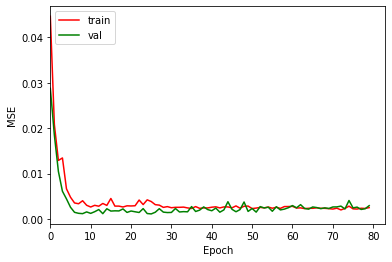

In [13]:
plt.plot(model_train.history['loss'], color='r', )
plt.plot(model_train.history['val_loss'], color='g')
plt.ylabel('MSE')
plt.xlabel('Epoch')
# plt.xscale('log')
plt.xlim(0)
plt.legend(['train', 'val'], loc='upper left')
# plt.savefig("loss_fs8.png", dpi=200)
# plt.savefig("loss_epochs_fs8_1000.png", dpi=200)


In [14]:
neural_model.save("FFNN_fs8.h5")

In [15]:
#uncer net
unet = np.sqrt(np.min(model_train.history['val_loss']))
unet**2, np.min(model_train.history['loss'])
print(np.min(model_train.history['loss']), np.min(model_train.history['val_loss']))
print(model_train.history['loss'][-1], model_train.history['val_loss'][-1])
# 0.0009567601955495775 0.0024885754100978374 mil epochs
# 0.0010785672347992659 0.0010806184727698565 500 epochs
# 0.0020020001102238894 0.0008378626080229878 100e
# 0.0021847975440323353 0.0009035465191118419 50e
# 0.002703879727050662 0.0013360671000555158 20e
### 100
# 0.001952524995431304 0.0008627769420854747
# 0.001952524995431304 0.002966993721202016


0.0020003505051136017 0.0011199653381481767
0.002504643052816391 0.002940311562269926


In [16]:
pred = neural_model.predict(z_test)
pred

array([[0.46286473, 0.06915069],
       [0.48648337, 0.09239583],
       [0.47028542, 0.09652269],
       [0.4491081 , 0.09780622],
       [0.41713303, 0.11624131]], dtype=float32)

In [17]:
#zor and yor are the original velues for z and [Hz, err]
zor = scalerz.inverse_transform(z.reshape(-1,1))
# yor = scalery.inverse_transform(y)

In [18]:
ranz = np.random.uniform(0, 2, size=1000)
r = scalerz.transform(ranz.reshape(-1, 1))
pred_random = neural_model.predict(r)
rr = scalerz.inverse_transform(r.reshape(-1,1))
# predy = scalery.inverse_transform(pred_random)


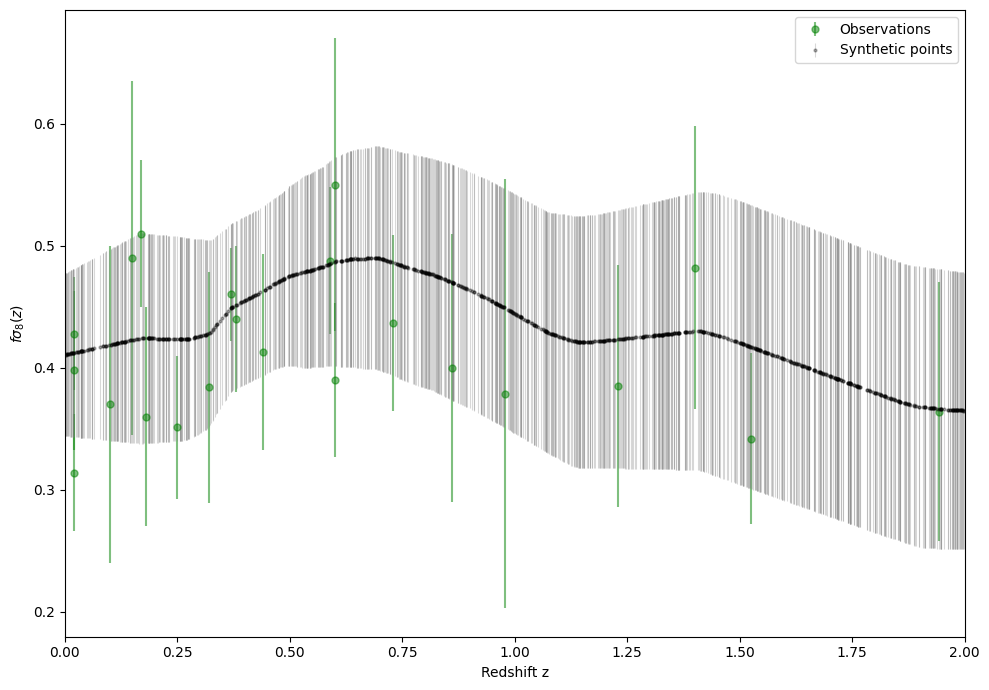

In [19]:
# plt.errorbar(zor, yor[:,0], yor[:,1], fmt='g.', markersize=15, label='Observations', alpha=0.5)
# plt.errorbar(rr, predy[:,0], predy[:,1], fmt='r.', markersize=5, label='Synthetic', alpha=0.01)
plt.figure(figsize=(10, 7), dpi=100)
plt.errorbar(zor, y[:,0], y[:,1], fmt='g.', markersize=10, label='Observations', alpha=0.5)
plt.errorbar(rr, pred_random[:,0], pred_random[:,1], label='Synthetic points', 
             markersize=2, fmt='o', 
             ecolor='gray', capthick=2, elinewidth=0.8, alpha=0.3, c='k',)
plt.xlabel("Redshift z")
plt.ylabel("$f\sigma_8(z)$")
plt.xlim(0, 2)
plt.tight_layout()
plt.legend(loc='upper right')
# plt.legend()
# plt.savefig("synthetic_fs8_20.png")

In [20]:
from functools import partial
# Cosmological constants
Om = 0.27
# variance network
s8 = 0.8
w0 = -1

In [21]:
def Ezlcdm(a):
    return np.sqrt(Om*(1/a)**3 + 1 - Om)

def RHSquared_a_lcdm(a):
#         return Ezlcdm(a)**2
    return Om*(1/a)**3 + 1 - Om

def RHSquared_a_owacdm(a, w0, wa):
#         return Ezlcdm(a)**2
    rhow = a**(-3*(1.0+w0+wa))*np.exp(-3*wa*(1-a))
    return (Om/a**3+(1.0-Om)*rhow)

  
def growth_lcdm(z):
    # Equation 7.77 from Doddie
    af = 1./(1. + z)
    r = intg.quad(GrowthIntegrand_a_lcdm, 1e-7, af)
    gr = np.sqrt(RHSquared_a_lcdm(af))*r[0]  # assume precision is ok
    gr *= 5/2.*Om
    return gr
    

def growth_owacdm(z, w0, wa):
    # Equation 7.77 from Doddie
    af = 1./(1. + z)
    r = intg.quad(GrowthIntegrand_a_owacdm, 1e-7, af, args=(w0, wa))
    gr = np.sqrt(RHSquared_a_lcdm(af))*r[0]  # assume precision is ok
    gr *= 5/2.*Om
    return gr

# returns the growth factor as a function of redshift
def GrowthIntegrand_a_lcdm(a):
    rhsquareda = RHSquared_a_lcdm(a) 
    return 1./(rhsquareda*a*a)**(1.5)

def GrowthIntegrand_a_owacdm(a, w0, wa):
    rhsquareda = RHSquared_a_owacdm(a, w0=w0, wa=wa) 
    return 1./(rhsquareda*a*a)**(1.5)


def fs8lcdm(z):
    return -s8*(1+z)*derivative(growth_lcdm, z, dx=1e-6)/growth_lcdm(0)

def fs8owacdm(z, w0=-1, wa=0):
    return -s8*(1+z)*derivative(growth_owacdm, z, dx=1e-6, args=(w0, wa))/growth_owacdm(0, w0, wa)


# def Hlcdm(a, H0=73.24):
#     z = 1./a-1
#     return H0 * np.sqrt(Om*(1+z)**3 + 1 - Om)

In [22]:
z = np.linspace(0.0, 2, 100)
flcdm = []
fowacdm1 = []
fowacdm2 = []
fowacdm3 = []

# flcdm = []
for zz in z:
    flcdm.append(fs8lcdm(zz))
    fowacdm1.append(fs8owacdm(zz, w0=-1, wa=0.5))
    fowacdm2.append(fs8owacdm(zz, w0=-1, wa=-0.5))
    fowacdm3.append(fs8owacdm(zz, w0=-1, wa=0.0))
    
flcdm = np.array(flcdm)
fowacdm1 = np.array(fowacdm1)
fowacdm2 = np.array(fowacdm2)
fowacdm3 = np.array(fowacdm3)


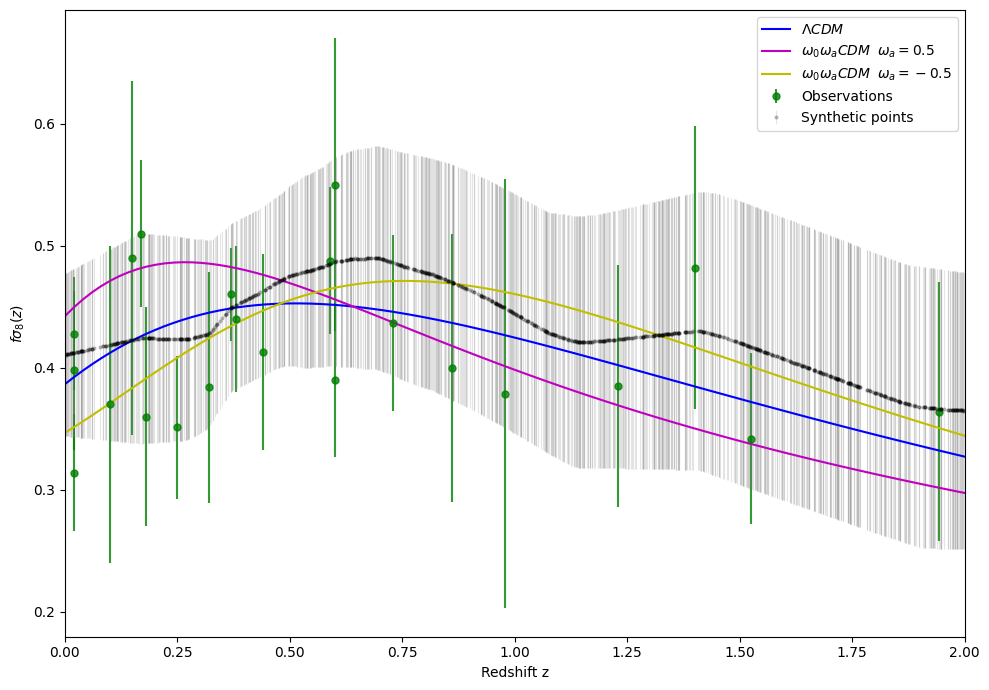

In [23]:
z = np.linspace(0, 2, 100)
plt.figure(figsize=(10, 7), dpi=100)

plt.errorbar(zor, y[:,0], y[:,1], fmt='g.', markersize=10, label='Observations', alpha=0.8)
plt.errorbar(rr, pred_random[:,0], pred_random[:,1], label='Synthetic points', 
             markersize=2, fmt='o', 
             ecolor='gray', capthick=2, elinewidth=0.8, alpha=0.2, c='k',)

plt.plot(z, flcdm, label='$\Lambda CDM$', c='b')
plt.plot(z, fowacdm1, label='$\omega_0\omega_aCDM \;\; \omega_a=0.5$', c='m')
plt.plot(z, fowacdm2, label='$\omega_0\omega_aCDM \;\; \omega_a=-0.5$', c='y')
# plt.plot(z, fowacdm3, label='$\omega_0\omega_aCDM \;\; \omega_a=0$', c='brown')

plt.xlabel("Redshift z")
plt.ylabel("$f\sigma_8(z)$")
plt.xlim(0, 2)
plt.tight_layout()
plt.legend()

# plt.savefig("Syntheticfs8.png",dpi=800)

In [24]:
# pred_random.shape, r.shape

In [25]:
# randomselection = np.random.randint(0,1000,50)
randomselection = np.random.randint(0,1000,50)

rr_reduced = rr[randomselection,:]
# predy_reduced = predy[randomselection,:]
predy_reduced = pred_random[randomselection,:]

In [26]:
mookHz = np.concatenate((rr_reduced.reshape(-1,1), predy_reduced), axis=1)

# np.savetxt("annfs850_.dat",mookHz, delimiter=" ")

In [27]:
mookHz

array([[0.02850377, 0.41298839, 0.069818  ],
       [0.41594122, 0.45828748, 0.06883134],
       [1.16253234, 0.42142808, 0.10365477],
       [0.19173172, 0.42414433, 0.08566891],
       [1.31931893, 0.42693511, 0.10994136],
       [1.8879081 , 0.36909303, 0.11469398],
       [0.34505208, 0.43854001, 0.07205656],
       [1.36383725, 0.42862847, 0.11195701],
       [1.08183393, 0.42780963, 0.09938662],
       [1.44521974, 0.4273397 , 0.11579598],
       [0.49906696, 0.47515732, 0.07354429],
       [0.57198391, 0.48280656, 0.08175553],
       [1.78389847, 0.38193896, 0.11484103],
       [1.23705475, 0.42380598, 0.10621665],
       [0.47908246, 0.47137037, 0.0709383 ],
       [1.61974989, 0.40433943, 0.11573228],
       [0.71664542, 0.4878186 , 0.09227072],
       [0.63735497, 0.48934349, 0.08874762],
       [0.09859551, 0.41867793, 0.07815714],
       [0.72353184, 0.48713008, 0.09233525],
       [0.92478831, 0.45929635, 0.09740669],
       [1.0837164 , 0.42756307, 0.0995256 ],
       [0.

In [28]:
predy_reduced[:,1]

array([0.069818  , 0.06883134, 0.10365477, 0.08566891, 0.10994136,
       0.11469398, 0.07205656, 0.11195701, 0.09938662, 0.11579598,
       0.07354429, 0.08175553, 0.11484103, 0.10621665, 0.0709383 ,
       0.11573228, 0.09227072, 0.08874762, 0.07815714, 0.09233525,
       0.09740669, 0.0995256 , 0.0837366 , 0.11370131, 0.11528619,
       0.08410247, 0.07405966, 0.09740579, 0.11370131, 0.09771246,
       0.11629717, 0.08317171, 0.11415651, 0.0931195 , 0.11627287,
       0.06929399, 0.11496341, 0.09775735, 0.0955794 , 0.11579598,
       0.11613373, 0.09672126, 0.09775735, 0.07440257, 0.11498381,
       0.0739689 , 0.09876984, 0.10064363, 0.08139724, 0.10590276],
      dtype=float32)

In [29]:
error  = predy_reduced[:,1]**2
error

array([0.00487455, 0.00473775, 0.01074431, 0.00733916, 0.0120871 ,
       0.01315471, 0.00519215, 0.01253437, 0.0098777 , 0.01340871,
       0.00540876, 0.00668397, 0.01318846, 0.01128198, 0.00503224,
       0.01339396, 0.00851389, 0.00787614, 0.00610854, 0.0085258 ,
       0.00948806, 0.00990534, 0.00701182, 0.01292799, 0.0132909 ,
       0.00707322, 0.00548483, 0.00948789, 0.01292799, 0.00954772,
       0.01352503, 0.00691753, 0.01303171, 0.00867124, 0.01351938,
       0.00480166, 0.01321659, 0.0095565 , 0.00913542, 0.01340871,
       0.01348704, 0.009355  , 0.0095565 , 0.00553574, 0.01322128,
       0.0054714 , 0.00975548, 0.01012914, 0.00662551, 0.0112154 ],
      dtype=float32)

In [30]:
diagcov = np.diag(error) #inverso
# np.savetxt("annfs8_cov50_.dat", diagcov, delimiter= " ", header="#50 50")
np.shape(diagcov)

(50, 50)

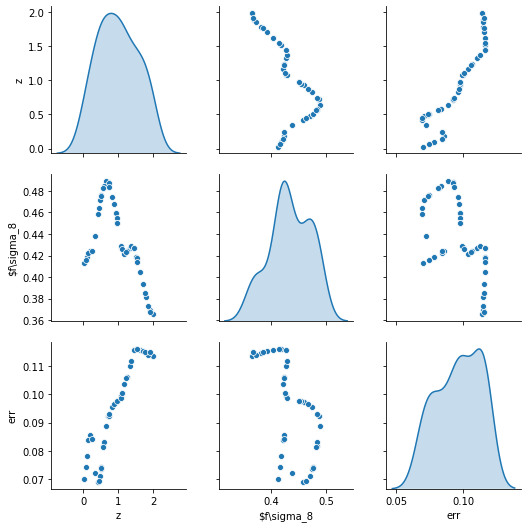

In [31]:
dfMook = pd.DataFrame(mookHz, columns=['z', '$f\sigma_8', 'err'])
sns.pairplot(dfMook, diag_kind="kde")
# plt.savefig("dist50fs8fake_.png")

In [32]:
from astroNN.nn.layers import MCDropout

In [33]:
yy = y[:,0].reshape(-1,1)
zz = z
split = 0.8
ntrain = int(split * len(zz))
indx = [ntrain]
zz_train, zz_test = np.split(zz, indx)
yy_train, yy_test = np.split(yy, indx)
np.shape(zz_train), np.shape(yy_train), np.shape(zz_test), np.shape(yy_test)

((80,), (22, 1), (20,), (0, 1))

In [77]:
def model_regression_dropout(num_hidden):
    # Defeine Keras model for regression
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.InputLayer(batch_input_shape=((None, 1))))
    model.add(Dense(units=num_hidden[0], 
#                     kernel_regularizer=tf.keras.regularizers.l2(1e-4),
#                     kernel_initializer='he_normal', 
                    activation='relu'))
    model.add(MCDropout(0.1))
    model.add(Dense(units=num_hidden[1], 
#                     kernel_regularizer=tf.keras.regularizers.l2(1e-4),
#                     kernel_initializer='he_normal', 
                    activation='relu'))
    model.add(MCDropout(0.1))
    model.add(Dense(units=num_hidden[2], 
#                     kernel_regularizer=tf.keras.regularizers.l2(1e-4),
#                     kernel_initializer='he_normal', 
                    activation='relu'))
    model.add(MCDropout(0.1))
    model.add(Dense(units=2, activation="linear"))
    return model

#Define some parameter
batch_size = 4
# optimizer = Adam(lr=.005)
optimizer = Adam(lr=0.0001)


# Compile Keras model
model2 = model_regression_dropout(num_hidden=[100, 50, 50])
model2.compile(loss='mse', optimizer=optimizer) 
# model2_train = model.fit(zz_train, yy_train, 
# #                          validation_split=0.0, 
#                          batch_size=batch_size, epochs=1000, verbose=1,
#                          validation_data=(zz_test, yy_test))    
model2_train = model2.fit(z_train, y_train, batch_size=batch_size,
                                    epochs=2000,verbose=1,
                                    validation_data=(z_test, y_test))

Epoch 1/2000
5/5 [==============================] - 0s 21ms/step - loss: 0.0896 - val_loss: 0.0903
Epoch 2/2000
5/5 [==============================] - 0s 4ms/step - loss: 0.0849 - val_loss: 0.0689
Epoch 3/2000
5/5 [==============================] - 0s 4ms/step - loss: 0.0790 - val_loss: 0.0652
Epoch 4/2000
5/5 [==============================] - 0s 4ms/step - loss: 0.0801 - val_loss: 0.0756
Epoch 5/2000
5/5 [==============================] - 0s 4ms/step - loss: 0.0701 - val_loss: 0.0734
Epoch 6/2000
5/5 [==============================] - 0s 4ms/step - loss: 0.0695 - val_loss: 0.0617
Epoch 7/2000
5/5 [==============================] - 0s 4ms/step - loss: 0.0588 - val_loss: 0.0565
Epoch 8/2000
5/5 [==============================] - 0s 4ms/step - loss: 0.0637 - val_loss: 0.0582
Epoch 9/2000
5/5 [==============================] - 0s 5ms/step - loss: 0.0590 - val_loss: 0.0516
Epoch 10/2000
5/5 [==============================] - 0s 5ms/step - loss: 0.0543 - val_loss: 0.0494
Epoch 11/2000
5/5 

Epoch 84/2000
5/5 [==============================] - 0s 4ms/step - loss: 0.0090 - val_loss: 0.0152
Epoch 85/2000
5/5 [==============================] - 0s 3ms/step - loss: 0.0105 - val_loss: 0.0103
Epoch 86/2000
5/5 [==============================] - 0s 4ms/step - loss: 0.0092 - val_loss: 0.0108
Epoch 87/2000
5/5 [==============================] - 0s 3ms/step - loss: 0.0146 - val_loss: 0.0122
Epoch 88/2000
5/5 [==============================] - 0s 4ms/step - loss: 0.0090 - val_loss: 0.0062
Epoch 89/2000
5/5 [==============================] - 0s 3ms/step - loss: 0.0098 - val_loss: 0.0067
Epoch 90/2000
5/5 [==============================] - 0s 3ms/step - loss: 0.0106 - val_loss: 0.0086
Epoch 91/2000
5/5 [==============================] - 0s 4ms/step - loss: 0.0068 - val_loss: 0.0087
Epoch 92/2000
5/5 [==============================] - 0s 4ms/step - loss: 0.0098 - val_loss: 0.0068
Epoch 93/2000
5/5 [==============================] - 0s 4ms/step - loss: 0.0095 - val_loss: 0.0136
Epoch 94/2

5/5 [==============================] - 0s 3ms/step - loss: 0.0051 - val_loss: 0.0067
Epoch 167/2000
5/5 [==============================] - 0s 4ms/step - loss: 0.0072 - val_loss: 0.0028
Epoch 168/2000
5/5 [==============================] - 0s 4ms/step - loss: 0.0050 - val_loss: 0.0048
Epoch 169/2000
5/5 [==============================] - 0s 3ms/step - loss: 0.0067 - val_loss: 0.0053
Epoch 170/2000
5/5 [==============================] - 0s 3ms/step - loss: 0.0057 - val_loss: 0.0034
Epoch 171/2000
5/5 [==============================] - 0s 4ms/step - loss: 0.0089 - val_loss: 0.0031
Epoch 172/2000
5/5 [==============================] - 0s 3ms/step - loss: 0.0067 - val_loss: 0.0023
Epoch 173/2000
5/5 [==============================] - 0s 3ms/step - loss: 0.0077 - val_loss: 0.0048
Epoch 174/2000
5/5 [==============================] - 0s 3ms/step - loss: 0.0071 - val_loss: 0.0046
Epoch 175/2000
5/5 [==============================] - 0s 3ms/step - loss: 0.0052 - val_loss: 0.0021
Epoch 176/2000


Epoch 248/2000
5/5 [==============================] - 0s 4ms/step - loss: 0.0065 - val_loss: 0.0033
Epoch 249/2000
5/5 [==============================] - 0s 3ms/step - loss: 0.0065 - val_loss: 0.0022
Epoch 250/2000
5/5 [==============================] - 0s 4ms/step - loss: 0.0039 - val_loss: 0.0082
Epoch 251/2000
5/5 [==============================] - 0s 4ms/step - loss: 0.0046 - val_loss: 0.0029
Epoch 252/2000
5/5 [==============================] - 0s 3ms/step - loss: 0.0053 - val_loss: 0.0020
Epoch 253/2000
5/5 [==============================] - 0s 4ms/step - loss: 0.0042 - val_loss: 0.0019
Epoch 254/2000
5/5 [==============================] - 0s 4ms/step - loss: 0.0042 - val_loss: 0.0038
Epoch 255/2000
5/5 [==============================] - 0s 4ms/step - loss: 0.0066 - val_loss: 0.0057
Epoch 256/2000
5/5 [==============================] - 0s 4ms/step - loss: 0.0065 - val_loss: 0.0015
Epoch 257/2000
5/5 [==============================] - 0s 4ms/step - loss: 0.0041 - val_loss: 0.0032


Epoch 330/2000
5/5 [==============================] - 0s 3ms/step - loss: 0.0048 - val_loss: 0.0018
Epoch 331/2000
5/5 [==============================] - 0s 4ms/step - loss: 0.0034 - val_loss: 0.0031
Epoch 332/2000
5/5 [==============================] - 0s 4ms/step - loss: 0.0036 - val_loss: 0.0021
Epoch 333/2000
5/5 [==============================] - 0s 3ms/step - loss: 0.0056 - val_loss: 0.0034
Epoch 334/2000
5/5 [==============================] - 0s 3ms/step - loss: 0.0033 - val_loss: 0.0059
Epoch 335/2000
5/5 [==============================] - 0s 3ms/step - loss: 0.0047 - val_loss: 0.0046
Epoch 336/2000
5/5 [==============================] - 0s 4ms/step - loss: 0.0023 - val_loss: 0.0025
Epoch 337/2000
5/5 [==============================] - 0s 3ms/step - loss: 0.0052 - val_loss: 0.0053
Epoch 338/2000
5/5 [==============================] - 0s 4ms/step - loss: 0.0054 - val_loss: 0.0019
Epoch 339/2000
5/5 [==============================] - 0s 4ms/step - loss: 0.0039 - val_loss: 0.0070


Epoch 412/2000
5/5 [==============================] - 0s 4ms/step - loss: 0.0032 - val_loss: 0.0028
Epoch 413/2000
5/5 [==============================] - 0s 4ms/step - loss: 0.0042 - val_loss: 0.0028
Epoch 414/2000
5/5 [==============================] - 0s 3ms/step - loss: 0.0032 - val_loss: 0.0027
Epoch 415/2000
5/5 [==============================] - 0s 4ms/step - loss: 0.0035 - val_loss: 0.0026
Epoch 416/2000
5/5 [==============================] - 0s 3ms/step - loss: 0.0034 - val_loss: 0.0057
Epoch 417/2000
5/5 [==============================] - 0s 3ms/step - loss: 0.0053 - val_loss: 0.0036
Epoch 418/2000
5/5 [==============================] - 0s 3ms/step - loss: 0.0062 - val_loss: 0.0038
Epoch 419/2000
5/5 [==============================] - 0s 3ms/step - loss: 0.0032 - val_loss: 0.0019
Epoch 420/2000
5/5 [==============================] - 0s 3ms/step - loss: 0.0026 - val_loss: 0.0022
Epoch 421/2000
5/5 [==============================] - 0s 3ms/step - loss: 0.0049 - val_loss: 0.0025


Epoch 494/2000
5/5 [==============================] - 0s 4ms/step - loss: 0.0053 - val_loss: 0.0015
Epoch 495/2000
5/5 [==============================] - 0s 4ms/step - loss: 0.0020 - val_loss: 0.0016
Epoch 496/2000
5/5 [==============================] - 0s 4ms/step - loss: 0.0039 - val_loss: 0.0020
Epoch 497/2000
5/5 [==============================] - 0s 4ms/step - loss: 0.0037 - val_loss: 0.0022
Epoch 498/2000
5/5 [==============================] - 0s 4ms/step - loss: 0.0047 - val_loss: 0.0040
Epoch 499/2000
5/5 [==============================] - 0s 3ms/step - loss: 0.0025 - val_loss: 0.0031
Epoch 500/2000
5/5 [==============================] - 0s 4ms/step - loss: 0.0037 - val_loss: 0.0037
Epoch 501/2000
5/5 [==============================] - 0s 4ms/step - loss: 0.0044 - val_loss: 0.0012
Epoch 502/2000
5/5 [==============================] - 0s 4ms/step - loss: 0.0042 - val_loss: 0.0037
Epoch 503/2000
5/5 [==============================] - 0s 3ms/step - loss: 0.0029 - val_loss: 0.0040


Epoch 576/2000
5/5 [==============================] - 0s 3ms/step - loss: 0.0037 - val_loss: 0.0019
Epoch 577/2000
5/5 [==============================] - 0s 4ms/step - loss: 0.0048 - val_loss: 0.0031
Epoch 578/2000
5/5 [==============================] - 0s 4ms/step - loss: 0.0045 - val_loss: 0.0026
Epoch 579/2000
5/5 [==============================] - 0s 4ms/step - loss: 0.0048 - val_loss: 0.0020
Epoch 580/2000
5/5 [==============================] - 0s 4ms/step - loss: 0.0031 - val_loss: 0.0042
Epoch 581/2000
5/5 [==============================] - 0s 3ms/step - loss: 0.0040 - val_loss: 0.0011
Epoch 582/2000
5/5 [==============================] - 0s 4ms/step - loss: 0.0039 - val_loss: 0.0030
Epoch 583/2000
5/5 [==============================] - 0s 3ms/step - loss: 0.0037 - val_loss: 0.0018
Epoch 584/2000
5/5 [==============================] - 0s 3ms/step - loss: 0.0020 - val_loss: 0.0017
Epoch 585/2000
5/5 [==============================] - 0s 3ms/step - loss: 0.0036 - val_loss: 0.0062


Epoch 658/2000
5/5 [==============================] - 0s 4ms/step - loss: 0.0023 - val_loss: 0.0028
Epoch 659/2000
5/5 [==============================] - 0s 3ms/step - loss: 0.0043 - val_loss: 0.0014
Epoch 660/2000
5/5 [==============================] - 0s 3ms/step - loss: 0.0038 - val_loss: 0.0017
Epoch 661/2000
5/5 [==============================] - 0s 3ms/step - loss: 0.0043 - val_loss: 5.8848e-04
Epoch 662/2000
5/5 [==============================] - 0s 3ms/step - loss: 0.0028 - val_loss: 0.0031
Epoch 663/2000
5/5 [==============================] - 0s 3ms/step - loss: 0.0029 - val_loss: 0.0038
Epoch 664/2000
5/5 [==============================] - 0s 3ms/step - loss: 0.0030 - val_loss: 0.0012
Epoch 665/2000
5/5 [==============================] - 0s 3ms/step - loss: 0.0035 - val_loss: 0.0039
Epoch 666/2000
5/5 [==============================] - 0s 4ms/step - loss: 0.0054 - val_loss: 9.3075e-04
Epoch 667/2000
5/5 [==============================] - 0s 4ms/step - loss: 0.0032 - val_loss:

Epoch 740/2000
5/5 [==============================] - 0s 4ms/step - loss: 0.0033 - val_loss: 0.0020
Epoch 741/2000
5/5 [==============================] - 0s 4ms/step - loss: 0.0029 - val_loss: 0.0022
Epoch 742/2000
5/5 [==============================] - 0s 4ms/step - loss: 0.0047 - val_loss: 0.0027
Epoch 743/2000
5/5 [==============================] - 0s 3ms/step - loss: 0.0029 - val_loss: 0.0027
Epoch 744/2000
5/5 [==============================] - 0s 4ms/step - loss: 0.0036 - val_loss: 0.0053
Epoch 745/2000
5/5 [==============================] - 0s 4ms/step - loss: 0.0039 - val_loss: 0.0023
Epoch 746/2000
5/5 [==============================] - 0s 6ms/step - loss: 0.0032 - val_loss: 0.0026
Epoch 747/2000
5/5 [==============================] - 0s 5ms/step - loss: 0.0029 - val_loss: 0.0044
Epoch 748/2000
5/5 [==============================] - 0s 3ms/step - loss: 0.0032 - val_loss: 0.0020
Epoch 749/2000
5/5 [==============================] - 0s 3ms/step - loss: 0.0022 - val_loss: 0.0029


Epoch 822/2000
5/5 [==============================] - 0s 4ms/step - loss: 0.0031 - val_loss: 0.0023
Epoch 823/2000
5/5 [==============================] - 0s 4ms/step - loss: 0.0039 - val_loss: 0.0022
Epoch 824/2000
5/5 [==============================] - 0s 4ms/step - loss: 0.0034 - val_loss: 0.0022
Epoch 825/2000
5/5 [==============================] - 0s 4ms/step - loss: 0.0035 - val_loss: 0.0024
Epoch 826/2000
5/5 [==============================] - 0s 4ms/step - loss: 0.0027 - val_loss: 0.0029
Epoch 827/2000
5/5 [==============================] - 0s 5ms/step - loss: 0.0031 - val_loss: 0.0016
Epoch 828/2000
5/5 [==============================] - 0s 4ms/step - loss: 0.0038 - val_loss: 0.0011
Epoch 829/2000
5/5 [==============================] - 0s 5ms/step - loss: 0.0048 - val_loss: 0.0034
Epoch 830/2000
5/5 [==============================] - 0s 4ms/step - loss: 0.0026 - val_loss: 0.0021
Epoch 831/2000
5/5 [==============================] - 0s 5ms/step - loss: 0.0035 - val_loss: 0.0023


Epoch 904/2000
5/5 [==============================] - 0s 3ms/step - loss: 0.0027 - val_loss: 0.0011
Epoch 905/2000
5/5 [==============================] - 0s 3ms/step - loss: 0.0032 - val_loss: 0.0034
Epoch 906/2000
5/5 [==============================] - 0s 3ms/step - loss: 0.0030 - val_loss: 0.0032
Epoch 907/2000
5/5 [==============================] - 0s 3ms/step - loss: 0.0035 - val_loss: 0.0022
Epoch 908/2000
5/5 [==============================] - 0s 3ms/step - loss: 0.0043 - val_loss: 0.0022
Epoch 909/2000
5/5 [==============================] - 0s 4ms/step - loss: 0.0034 - val_loss: 0.0018
Epoch 910/2000
5/5 [==============================] - 0s 3ms/step - loss: 0.0029 - val_loss: 0.0022
Epoch 911/2000
5/5 [==============================] - 0s 3ms/step - loss: 0.0026 - val_loss: 0.0037
Epoch 912/2000
5/5 [==============================] - 0s 4ms/step - loss: 0.0040 - val_loss: 0.0038
Epoch 913/2000
5/5 [==============================] - 0s 3ms/step - loss: 0.0031 - val_loss: 0.0032


Epoch 986/2000
5/5 [==============================] - 0s 4ms/step - loss: 0.0026 - val_loss: 0.0044
Epoch 987/2000
5/5 [==============================] - 0s 4ms/step - loss: 0.0027 - val_loss: 0.0021
Epoch 988/2000
5/5 [==============================] - 0s 4ms/step - loss: 0.0039 - val_loss: 0.0038
Epoch 989/2000
5/5 [==============================] - 0s 5ms/step - loss: 0.0025 - val_loss: 0.0044
Epoch 990/2000
5/5 [==============================] - 0s 4ms/step - loss: 0.0031 - val_loss: 0.0017
Epoch 991/2000
5/5 [==============================] - 0s 4ms/step - loss: 0.0032 - val_loss: 0.0019
Epoch 992/2000
5/5 [==============================] - 0s 4ms/step - loss: 0.0038 - val_loss: 0.0026
Epoch 993/2000
5/5 [==============================] - 0s 4ms/step - loss: 0.0037 - val_loss: 0.0012
Epoch 994/2000
5/5 [==============================] - 0s 4ms/step - loss: 0.0032 - val_loss: 0.0045
Epoch 995/2000
5/5 [==============================] - 0s 3ms/step - loss: 0.0030 - val_loss: 0.0028


Epoch 1067/2000
5/5 [==============================] - 0s 3ms/step - loss: 0.0030 - val_loss: 0.0024
Epoch 1068/2000
5/5 [==============================] - 0s 3ms/step - loss: 0.0024 - val_loss: 0.0023
Epoch 1069/2000
5/5 [==============================] - 0s 3ms/step - loss: 0.0028 - val_loss: 0.0053
Epoch 1070/2000
5/5 [==============================] - 0s 3ms/step - loss: 0.0032 - val_loss: 0.0054
Epoch 1071/2000
5/5 [==============================] - ETA: 0s - loss: 0.003 - 0s 3ms/step - loss: 0.0035 - val_loss: 0.0019
Epoch 1072/2000
5/5 [==============================] - ETA: 0s - loss: 0.004 - 0s 3ms/step - loss: 0.0032 - val_loss: 0.0044
Epoch 1073/2000
5/5 [==============================] - 0s 3ms/step - loss: 0.0018 - val_loss: 0.0018
Epoch 1074/2000
5/5 [==============================] - ETA: 0s - loss: 0.005 - 0s 3ms/step - loss: 0.0027 - val_loss: 0.0024
Epoch 1075/2000
5/5 [==============================] - 0s 3ms/step - loss: 0.0032 - val_loss: 0.0025
Epoch 1076/2000
5/5

5/5 [==============================] - 0s 4ms/step - loss: 0.0031 - val_loss: 0.0022
Epoch 1148/2000
5/5 [==============================] - 0s 4ms/step - loss: 0.0027 - val_loss: 0.0022
Epoch 1149/2000
5/5 [==============================] - 0s 3ms/step - loss: 0.0024 - val_loss: 0.0022
Epoch 1150/2000
5/5 [==============================] - 0s 3ms/step - loss: 0.0029 - val_loss: 0.0016
Epoch 1151/2000
5/5 [==============================] - 0s 3ms/step - loss: 0.0022 - val_loss: 0.0057
Epoch 1152/2000
5/5 [==============================] - 0s 3ms/step - loss: 0.0030 - val_loss: 0.0019
Epoch 1153/2000
5/5 [==============================] - 0s 4ms/step - loss: 0.0030 - val_loss: 0.0033
Epoch 1154/2000
5/5 [==============================] - 0s 4ms/step - loss: 0.0043 - val_loss: 0.0017
Epoch 1155/2000
5/5 [==============================] - 0s 4ms/step - loss: 0.0024 - val_loss: 0.0024
Epoch 1156/2000
5/5 [==============================] - 0s 4ms/step - loss: 0.0029 - val_loss: 0.0019
Epoch 

5/5 [==============================] - 0s 4ms/step - loss: 0.0025 - val_loss: 0.0022
Epoch 1229/2000
5/5 [==============================] - 0s 3ms/step - loss: 0.0028 - val_loss: 0.0028
Epoch 1230/2000
5/5 [==============================] - 0s 4ms/step - loss: 0.0043 - val_loss: 0.0014
Epoch 1231/2000
5/5 [==============================] - 0s 3ms/step - loss: 0.0022 - val_loss: 0.0023
Epoch 1232/2000
5/5 [==============================] - 0s 3ms/step - loss: 0.0025 - val_loss: 0.0022
Epoch 1233/2000
5/5 [==============================] - 0s 3ms/step - loss: 0.0032 - val_loss: 0.0029
Epoch 1234/2000
5/5 [==============================] - 0s 3ms/step - loss: 0.0017 - val_loss: 0.0019
Epoch 1235/2000
5/5 [==============================] - 0s 3ms/step - loss: 0.0023 - val_loss: 0.0032
Epoch 1236/2000
5/5 [==============================] - 0s 3ms/step - loss: 0.0032 - val_loss: 0.0029
Epoch 1237/2000
5/5 [==============================] - 0s 3ms/step - loss: 0.0034 - val_loss: 0.0034
Epoch 

Epoch 1309/2000
5/5 [==============================] - 0s 3ms/step - loss: 0.0025 - val_loss: 0.0032
Epoch 1310/2000
5/5 [==============================] - 0s 3ms/step - loss: 0.0018 - val_loss: 0.0020
Epoch 1311/2000
5/5 [==============================] - 0s 3ms/step - loss: 0.0030 - val_loss: 0.0017
Epoch 1312/2000
5/5 [==============================] - 0s 4ms/step - loss: 0.0023 - val_loss: 0.0022
Epoch 1313/2000
5/5 [==============================] - 0s 3ms/step - loss: 0.0025 - val_loss: 0.0015
Epoch 1314/2000
5/5 [==============================] - 0s 3ms/step - loss: 0.0024 - val_loss: 0.0027
Epoch 1315/2000
5/5 [==============================] - 0s 3ms/step - loss: 0.0029 - val_loss: 0.0031
Epoch 1316/2000
5/5 [==============================] - 0s 3ms/step - loss: 0.0029 - val_loss: 0.0022
Epoch 1317/2000
5/5 [==============================] - 0s 3ms/step - loss: 0.0028 - val_loss: 0.0022
Epoch 1318/2000
5/5 [==============================] - 0s 3ms/step - loss: 0.0024 - val_los

5/5 [==============================] - 0s 5ms/step - loss: 0.0023 - val_loss: 0.0037
Epoch 1391/2000
5/5 [==============================] - 0s 5ms/step - loss: 0.0018 - val_loss: 0.0023
Epoch 1392/2000
5/5 [==============================] - 0s 4ms/step - loss: 0.0027 - val_loss: 0.0044
Epoch 1393/2000
5/5 [==============================] - 0s 4ms/step - loss: 0.0042 - val_loss: 0.0036
Epoch 1394/2000
5/5 [==============================] - 0s 4ms/step - loss: 0.0034 - val_loss: 0.0028
Epoch 1395/2000
5/5 [==============================] - 0s 5ms/step - loss: 0.0034 - val_loss: 0.0026
Epoch 1396/2000
5/5 [==============================] - 0s 5ms/step - loss: 0.0027 - val_loss: 0.0025
Epoch 1397/2000
5/5 [==============================] - 0s 5ms/step - loss: 0.0023 - val_loss: 0.0021
Epoch 1398/2000
5/5 [==============================] - 0s 5ms/step - loss: 0.0031 - val_loss: 0.0023
Epoch 1399/2000
5/5 [==============================] - 0s 5ms/step - loss: 0.0037 - val_loss: 0.0018
Epoch 

5/5 [==============================] - 0s 5ms/step - loss: 0.0022 - val_loss: 0.0021
Epoch 1472/2000
5/5 [==============================] - 0s 4ms/step - loss: 0.0024 - val_loss: 0.0020
Epoch 1473/2000
5/5 [==============================] - 0s 4ms/step - loss: 0.0027 - val_loss: 0.0062
Epoch 1474/2000
5/5 [==============================] - 0s 4ms/step - loss: 0.0036 - val_loss: 0.0019
Epoch 1475/2000
5/5 [==============================] - 0s 4ms/step - loss: 0.0027 - val_loss: 0.0020
Epoch 1476/2000
5/5 [==============================] - 0s 4ms/step - loss: 0.0029 - val_loss: 0.0025
Epoch 1477/2000
5/5 [==============================] - 0s 4ms/step - loss: 0.0024 - val_loss: 0.0030
Epoch 1478/2000
5/5 [==============================] - 0s 4ms/step - loss: 0.0035 - val_loss: 0.0024
Epoch 1479/2000
5/5 [==============================] - 0s 4ms/step - loss: 0.0033 - val_loss: 0.0027
Epoch 1480/2000
5/5 [==============================] - 0s 4ms/step - loss: 0.0024 - val_loss: 0.0022
Epoch 

5/5 [==============================] - 0s 3ms/step - loss: 0.0027 - val_loss: 0.0022
Epoch 1553/2000
5/5 [==============================] - 0s 3ms/step - loss: 0.0037 - val_loss: 0.0037
Epoch 1554/2000
5/5 [==============================] - 0s 3ms/step - loss: 0.0034 - val_loss: 0.0032
Epoch 1555/2000
5/5 [==============================] - 0s 3ms/step - loss: 0.0026 - val_loss: 0.0037
Epoch 1556/2000
5/5 [==============================] - 0s 3ms/step - loss: 0.0025 - val_loss: 0.0023
Epoch 1557/2000
5/5 [==============================] - 0s 3ms/step - loss: 0.0025 - val_loss: 0.0024
Epoch 1558/2000
5/5 [==============================] - 0s 3ms/step - loss: 0.0032 - val_loss: 0.0025
Epoch 1559/2000
5/5 [==============================] - 0s 3ms/step - loss: 0.0028 - val_loss: 0.0026
Epoch 1560/2000
5/5 [==============================] - 0s 3ms/step - loss: 0.0031 - val_loss: 0.0039
Epoch 1561/2000
5/5 [==============================] - 0s 3ms/step - loss: 0.0024 - val_loss: 0.0030
Epoch 

Epoch 1633/2000
5/5 [==============================] - 0s 3ms/step - loss: 0.0023 - val_loss: 0.0017
Epoch 1634/2000
5/5 [==============================] - 0s 3ms/step - loss: 0.0027 - val_loss: 0.0019
Epoch 1635/2000
5/5 [==============================] - 0s 3ms/step - loss: 0.0027 - val_loss: 0.0023
Epoch 1636/2000
5/5 [==============================] - 0s 3ms/step - loss: 0.0024 - val_loss: 0.0016
Epoch 1637/2000
5/5 [==============================] - 0s 3ms/step - loss: 0.0024 - val_loss: 0.0029
Epoch 1638/2000
5/5 [==============================] - 0s 3ms/step - loss: 0.0033 - val_loss: 0.0015
Epoch 1639/2000
5/5 [==============================] - 0s 3ms/step - loss: 0.0030 - val_loss: 0.0018
Epoch 1640/2000
5/5 [==============================] - 0s 3ms/step - loss: 0.0030 - val_loss: 0.0024
Epoch 1641/2000
5/5 [==============================] - 0s 3ms/step - loss: 0.0022 - val_loss: 0.0026
Epoch 1642/2000
5/5 [==============================] - 0s 3ms/step - loss: 0.0019 - val_los

5/5 [==============================] - 0s 3ms/step - loss: 0.0018 - val_loss: 0.0043
Epoch 1715/2000
5/5 [==============================] - 0s 3ms/step - loss: 0.0021 - val_loss: 0.0046
Epoch 1716/2000
5/5 [==============================] - 0s 3ms/step - loss: 0.0028 - val_loss: 0.0044
Epoch 1717/2000
5/5 [==============================] - 0s 3ms/step - loss: 0.0026 - val_loss: 0.0022
Epoch 1718/2000
5/5 [==============================] - 0s 3ms/step - loss: 0.0032 - val_loss: 0.0016
Epoch 1719/2000
5/5 [==============================] - 0s 3ms/step - loss: 0.0028 - val_loss: 0.0053
Epoch 1720/2000
5/5 [==============================] - 0s 3ms/step - loss: 0.0025 - val_loss: 0.0036
Epoch 1721/2000
5/5 [==============================] - 0s 3ms/step - loss: 0.0021 - val_loss: 0.0017
Epoch 1722/2000
5/5 [==============================] - 0s 3ms/step - loss: 0.0027 - val_loss: 0.0039
Epoch 1723/2000
5/5 [==============================] - 0s 3ms/step - loss: 0.0027 - val_loss: 0.0025
Epoch 

5/5 [==============================] - 0s 4ms/step - loss: 0.0034 - val_loss: 0.0039
Epoch 1796/2000
5/5 [==============================] - 0s 4ms/step - loss: 0.0022 - val_loss: 0.0035
Epoch 1797/2000
5/5 [==============================] - 0s 6ms/step - loss: 0.0023 - val_loss: 0.0030
Epoch 1798/2000
5/5 [==============================] - 0s 5ms/step - loss: 0.0027 - val_loss: 0.0016
Epoch 1799/2000
5/5 [==============================] - 0s 6ms/step - loss: 0.0018 - val_loss: 0.0014
Epoch 1800/2000
5/5 [==============================] - 0s 4ms/step - loss: 0.0019 - val_loss: 0.0020
Epoch 1801/2000
5/5 [==============================] - 0s 4ms/step - loss: 0.0033 - val_loss: 0.0025
Epoch 1802/2000
5/5 [==============================] - 0s 4ms/step - loss: 0.0017 - val_loss: 0.0032
Epoch 1803/2000
5/5 [==============================] - 0s 4ms/step - loss: 0.0022 - val_loss: 0.0015
Epoch 1804/2000
5/5 [==============================] - 0s 4ms/step - loss: 0.0029 - val_loss: 0.0028
Epoch 

5/5 [==============================] - 0s 4ms/step - loss: 0.0020 - val_loss: 0.0018
Epoch 1877/2000
5/5 [==============================] - 0s 3ms/step - loss: 0.0033 - val_loss: 0.0023
Epoch 1878/2000
5/5 [==============================] - 0s 3ms/step - loss: 0.0020 - val_loss: 0.0017
Epoch 1879/2000
5/5 [==============================] - 0s 3ms/step - loss: 0.0025 - val_loss: 0.0016
Epoch 1880/2000
5/5 [==============================] - 0s 3ms/step - loss: 0.0028 - val_loss: 0.0024
Epoch 1881/2000
5/5 [==============================] - 0s 3ms/step - loss: 0.0026 - val_loss: 0.0023
Epoch 1882/2000
5/5 [==============================] - 0s 3ms/step - loss: 0.0026 - val_loss: 0.0025
Epoch 1883/2000
5/5 [==============================] - 0s 4ms/step - loss: 0.0024 - val_loss: 0.0032
Epoch 1884/2000
5/5 [==============================] - 0s 4ms/step - loss: 0.0018 - val_loss: 0.0024
Epoch 1885/2000
5/5 [==============================] - 0s 4ms/step - loss: 0.0019 - val_loss: 0.0015
Epoch 

5/5 [==============================] - 0s 3ms/step - loss: 0.0028 - val_loss: 0.0028
Epoch 1958/2000
5/5 [==============================] - 0s 3ms/step - loss: 0.0027 - val_loss: 0.0013
Epoch 1959/2000
5/5 [==============================] - 0s 3ms/step - loss: 0.0024 - val_loss: 0.0018
Epoch 1960/2000
5/5 [==============================] - 0s 3ms/step - loss: 0.0022 - val_loss: 0.0035
Epoch 1961/2000
5/5 [==============================] - 0s 3ms/step - loss: 0.0028 - val_loss: 0.0013
Epoch 1962/2000
5/5 [==============================] - 0s 4ms/step - loss: 0.0024 - val_loss: 0.0039
Epoch 1963/2000
5/5 [==============================] - 0s 4ms/step - loss: 0.0023 - val_loss: 7.7632e-04
Epoch 1964/2000
5/5 [==============================] - 0s 3ms/step - loss: 0.0030 - val_loss: 0.0023
Epoch 1965/2000
5/5 [==============================] - 0s 3ms/step - loss: 0.0030 - val_loss: 0.0026
Epoch 1966/2000
5/5 [==============================] - 0s 3ms/step - loss: 0.0022 - val_loss: 0.0020
Ep

In [78]:
# Generate test data
test_batch_size = 1000
# x_test = np.random.uniform(0, 2., test_batch_size)
x_test = np.linspace(0, 2., test_batch_size)

mc_dropout_num = 100  # Run Dropout 100 times
predictions = np.zeros((mc_dropout_num, test_batch_size, 2))
uncertainty = np.zeros((mc_dropout_num, test_batch_size, 1))
for i in range(mc_dropout_num):
    predictions[i] = model2.predict(scalerz.transform(x_test.reshape(-1,1)))
    
# get mean results and its varience
prediction_mc_dropout = np.mean(predictions, axis=0)
std_mc_dropout = np.std(predictions, axis=0)

In [79]:
np.mean(std_mc_dropout[:,0]), np.mean(std_mc_dropout[:,1])

(0.03029376961451616, 0.014295281200918355)

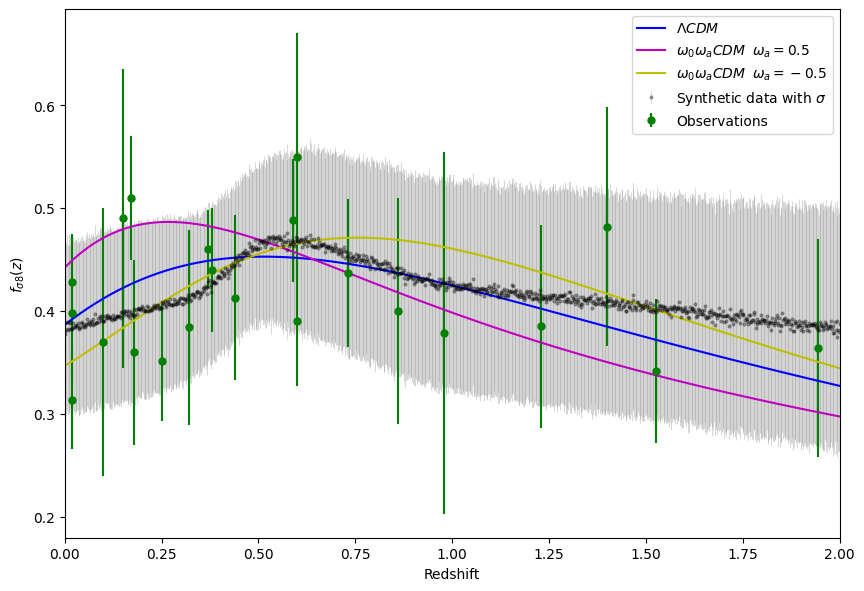

In [80]:
# Plotting
plt.figure(figsize=(10, 7), dpi=100)
# plt.figure(figsize=(5, 4), dpi=100)
sigma = np.sqrt(std_mc_dropout[:, 0]**2 + std_mc_dropout[:, 1]**2+ prediction_mc_dropout[:,1]**2)
plt.errorbar(x_test, prediction_mc_dropout[:,0], yerr=sigma, markersize=2, fmt='o', 
             ecolor='gray', capthick=2, elinewidth=0.8, alpha=0.3, c='k',
             label='Synthetic data with $\sigma$')

# plt.scatter(scalerz.inverse_transform(zz), yy, color='k', label='Original cosmic chronometers')
plt.errorbar(zor, y[:,0], y[:,1], fmt='g.', markersize=10, label='Observations')
plt.plot(z, flcdm, label='$\Lambda CDM$', c='b')
plt.plot(z, fowacdm1, label='$\omega_0\omega_aCDM \;\; \omega_a=0.5$', c='m')
plt.plot(z, fowacdm2, label='$\omega_0\omega_aCDM \;\; \omega_a=-0.5$', c='y')
# plt.plot(zmodel, Hlcdm(zmodel), label='$\Lambda CDM$ $H_0 = 73.24$', c='k')
# plt.plot(zmodel, Hlcdm(zmodel, H0=67.4), label='$\Lambda CDM$ $H_0 = 67.4$', c='b')
plt.xlim(0,2)
plt.xlabel('Redshift')
plt.ylabel('$f_{\sigma8}(z)$')
# plt.legend(loc='best')
plt.legend(loc='upper right')
# plt.show()
plt.savefig('fs8_dropout.png', dpi=200)

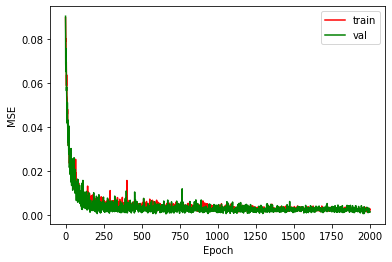

In [81]:
plt.plot(model2_train.history['loss'], color='r')
plt.plot(model2_train.history['val_loss'], color='g')
plt.ylabel('MSE')
plt.xlabel('Epoch')
# plt.xscale('log')
plt.legend(['train', 'val'], loc='upper right')
# plt.savefig('lossfs8dropout.png', dpi=100)

In [82]:
model2.save("FFNN+MC-DO_fs8.h5")

In [83]:
mookdpfs8 = np.concatenate((x_test.reshape(-1,1), prediction_mc_dropout), axis=1)

# np.savetxt("annfs850dropout.dat",mookdpfs8, delimiter=" ")

In [84]:
diagcov2 = np.diag(sigma**2) #inverso
# np.savetxt("annfs8_cov50dropout.dat", diagcov2, delimiter= " ", header="#50 50")

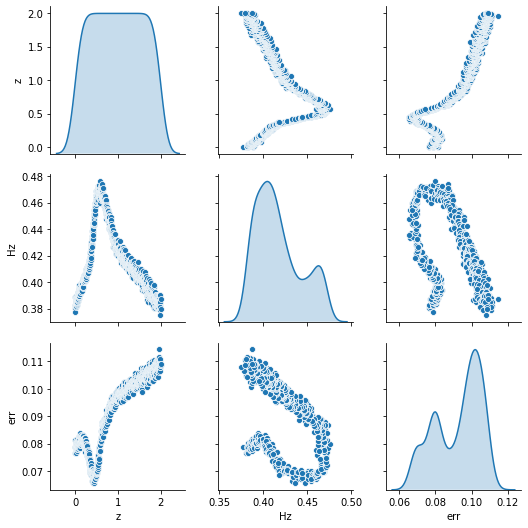

In [85]:
dfMook = pd.DataFrame(mookdpfs8, columns=['z', 'Hz', 'err'])
sns.pairplot(dfMook, diag_kind="kde")
# plt.savefig("50fs8dmookdropout.png")